# DPO: Direct Preference Optimization

**Goal**: Understand how DPO skips the reward model and trains directly on preferences.

## The Key Insight

RLHF: Train reward model → Use PPO to optimize policy against it

DPO: **Skip the reward model entirely**. Derive a loss that directly optimizes the policy from preference data.

## Why DPO?

| RLHF | DPO |
|------|-----|
| Train RM + run PPO (complex) | Single supervised loss (simple) |
| RM can be exploited (reward hacking) | No RM to exploit |
| PPO is unstable, many hyperparams | Stable, few hyperparams |
| Need RL infrastructure | Just needs supervised training |

Reference: Rafailov et al. "Direct Preference Optimization" (2023)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import copy

torch.manual_seed(42)
np.random.seed(42)

---
## 1. The DPO Derivation (Intuitive Version)

### Starting Point: RLHF Objective

$$\max_\theta \mathbb{E}\left[ r(x, y) - \beta \cdot D_{KL}(\pi_\theta \| \pi_{ref}) \right]$$

### The Closed-Form Solution

It turns out the **optimal policy** for this objective has a closed form:

$$\pi^*(y|x) = \frac{1}{Z(x)} \pi_{ref}(y|x) \cdot \exp\left(\frac{r(x,y)}{\beta}\right)$$

### Rearranging to Get the Implicit Reward

We can solve for the reward:

$$r(x, y) = \beta \log \frac{\pi_\theta(y|x)}{\pi_{ref}(y|x)} + \beta \log Z(x)$$

### The DPO Loss

Substituting this into the Bradley-Terry preference model and simplifying:

$$\mathcal{L}_{DPO} = -\mathbb{E}\left[ \log \sigma\left( \beta \log \frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \beta \log \frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)} \right) \right]$$

### In Plain English

DPO says: **increase the relative probability of preferred responses (vs reference), and decrease the relative probability of rejected responses.**

The `β` parameter controls how aggressively.

---
## 2. Same Toy Setup as RLHF Notebook

In [2]:
# Reuse the toy setup from notebook 06
N_CONTEXTS = 5
VOCAB_SIZE = 10
CONTEXT_DIM = 8

context_embeddings = torch.randn(N_CONTEXTS, CONTEXT_DIM)
true_preferences = torch.randn(N_CONTEXTS, VOCAB_SIZE)
true_preferences = torch.softmax(true_preferences * 2, dim=-1)

def get_true_reward(context_id, token_id):
    return true_preferences[context_id, token_id].item()

def get_human_comparison(context_id, token_a, token_b):
    r_a = get_true_reward(context_id, token_a)
    r_b = get_true_reward(context_id, token_b)
    prob_a = np.exp(r_a) / (np.exp(r_a) + np.exp(r_b))
    return 0 if np.random.random() < prob_a else 1


class ToyLM(nn.Module):
    def __init__(self, context_dim, vocab_size, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(context_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_size),
        )
    
    def forward(self, context):
        return self.net(context)
    
    def log_probs(self, context, tokens):
        """Get log probabilities for specific tokens."""
        logits = self.forward(context)
        return F.log_softmax(logits, dim=-1).gather(1, tokens.unsqueeze(1)).squeeze(1)
    
    def generate(self, context_id):
        context = context_embeddings[context_id].unsqueeze(0)
        dist = Categorical(logits=self.forward(context))
        return dist.sample().item()


# Train SFT model (same as RLHF notebook)
sft_model = ToyLM(CONTEXT_DIM, VOCAB_SIZE)
sft_optimizer = optim.Adam(sft_model.parameters(), lr=1e-2)

demo_data = []
for _ in range(500):
    ctx = np.random.randint(N_CONTEXTS)
    token = torch.multinomial(true_preferences[ctx], 1).item()
    demo_data.append((ctx, token))

for epoch in range(100):
    indices = np.random.permutation(len(demo_data))
    for i in range(0, len(indices), 32):
        batch = [demo_data[indices[j]] for j in range(i, min(i+32, len(indices)))]
        contexts = context_embeddings[torch.LongTensor([b[0] for b in batch])]
        targets = torch.LongTensor([b[1] for b in batch])
        loss = F.cross_entropy(sft_model(contexts), targets)
        sft_optimizer.zero_grad()
        loss.backward()
        sft_optimizer.step()

print("SFT model trained")

SFT model trained


In [3]:
# Collect preference data
preference_data = []
for _ in range(2000):
    ctx = np.random.randint(N_CONTEXTS)
    token_a = np.random.randint(VOCAB_SIZE)
    token_b = np.random.randint(VOCAB_SIZE)
    if token_a == token_b:
        continue
    winner = get_human_comparison(ctx, token_a, token_b)
    if winner == 0:
        preference_data.append((ctx, token_a, token_b))
    else:
        preference_data.append((ctx, token_b, token_a))

print(f"Collected {len(preference_data)} preference pairs")

Collected 1784 preference pairs


---
## 3. Implementing DPO

In [4]:
def dpo_loss(
    policy: ToyLM,
    ref_model: ToyLM,
    contexts: torch.Tensor,
    chosen_tokens: torch.Tensor,
    rejected_tokens: torch.Tensor,
    beta: float = 0.1,
) -> torch.Tensor:
    """
    Compute the DPO loss.
    
    L_DPO = -E[log σ(β (log π(y_w|x)/π_ref(y_w|x) - log π(y_l|x)/π_ref(y_l|x)))]
    
    Args:
        policy: Policy model being optimized
        ref_model: Frozen reference model
        contexts: Context embeddings [batch, dim]
        chosen_tokens: Preferred token ids [batch]
        rejected_tokens: Rejected token ids [batch]
        beta: Temperature parameter (controls preference strength)
    
    Returns:
        Scalar DPO loss
    """
    # Policy log probs
    pi_chosen = policy.log_probs(contexts, chosen_tokens)
    pi_rejected = policy.log_probs(contexts, rejected_tokens)
    
    # Reference log probs
    with torch.no_grad():
        ref_chosen = ref_model.log_probs(contexts, chosen_tokens)
        ref_rejected = ref_model.log_probs(contexts, rejected_tokens)
    
    # Log ratios
    chosen_logratios = pi_chosen - ref_chosen
    rejected_logratios = pi_rejected - ref_rejected
    
    # DPO loss
    logits = beta * (chosen_logratios - rejected_logratios)
    loss = -F.logsigmoid(logits).mean()
    
    return loss, {
        'chosen_reward': (beta * chosen_logratios).mean().item(),
        'rejected_reward': (beta * rejected_logratios).mean().item(),
        'reward_margin': (beta * (chosen_logratios - rejected_logratios)).mean().item(),
        'accuracy': (logits > 0).float().mean().item(),
    }

# Quick test
test_ctx = context_embeddings[:3]
test_chosen = torch.LongTensor([1, 2, 3])
test_rejected = torch.LongTensor([4, 5, 6])

ref_model = copy.deepcopy(sft_model)
for p in ref_model.parameters():
    p.requires_grad = False

loss, metrics = dpo_loss(sft_model, ref_model, test_ctx, test_chosen, test_rejected)
print(f"DPO loss: {loss.item():.4f}")
print(f"Metrics: {metrics}")

DPO loss: 0.6931
Metrics: {'chosen_reward': 0.0, 'rejected_reward': 0.0, 'reward_margin': 0.0, 'accuracy': 0.0}


In [5]:
def train_dpo(
    sft_model: ToyLM,
    preference_data: list,
    beta: float = 0.1,
    lr: float = 1e-3,
    n_epochs: int = 50,
    batch_size: int = 64,
) -> tuple:
    """
    Train a model with DPO.
    
    Args:
        sft_model: Starting (SFT) model
        preference_data: List of (context_id, chosen_token, rejected_token)
        beta: DPO temperature
        lr: Learning rate
        n_epochs: Training epochs
        batch_size: Batch size
    
    Returns:
        Tuple of (trained model, metrics history)
    """
    policy = copy.deepcopy(sft_model)
    ref_model = copy.deepcopy(sft_model)
    for p in ref_model.parameters():
        p.requires_grad = False
    
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    history = {'loss': [], 'accuracy': [], 'reward_margin': []}
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(preference_data))
        epoch_loss = 0
        epoch_acc = 0
        epoch_margin = 0
        n_batches = 0
        
        for i in range(0, len(indices), batch_size):
            batch_idx = indices[i:i+batch_size]
            batch = [preference_data[j] for j in batch_idx]
            
            ctx_ids = torch.LongTensor([b[0] for b in batch])
            chosen = torch.LongTensor([b[1] for b in batch])
            rejected = torch.LongTensor([b[2] for b in batch])
            contexts = context_embeddings[ctx_ids]
            
            loss, metrics = dpo_loss(policy, ref_model, contexts, chosen, rejected, beta)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_acc += metrics['accuracy']
            epoch_margin += metrics['reward_margin']
            n_batches += 1
        
        history['loss'].append(epoch_loss / n_batches)
        history['accuracy'].append(epoch_acc / n_batches)
        history['reward_margin'].append(epoch_margin / n_batches)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: loss={history['loss'][-1]:.4f}, "
                  f"acc={history['accuracy'][-1]:.1%}, "
                  f"margin={history['reward_margin'][-1]:.4f}")
    
    return policy, history

In [6]:
# Train DPO
print("Training DPO...\n")
dpo_policy, dpo_history = train_dpo(
    sft_model=sft_model,
    preference_data=preference_data,
    beta=0.1,
    lr=1e-3,
    n_epochs=50,
)

Training DPO...

Epoch 10: loss=0.6760, acc=56.9%, margin=0.0486
Epoch 20: loss=0.6697, acc=57.6%, margin=0.0805
Epoch 30: loss=0.6674, acc=58.0%, margin=0.0967
Epoch 40: loss=0.6665, acc=58.0%, margin=0.1046
Epoch 50: loss=0.6662, acc=58.4%, margin=0.1084


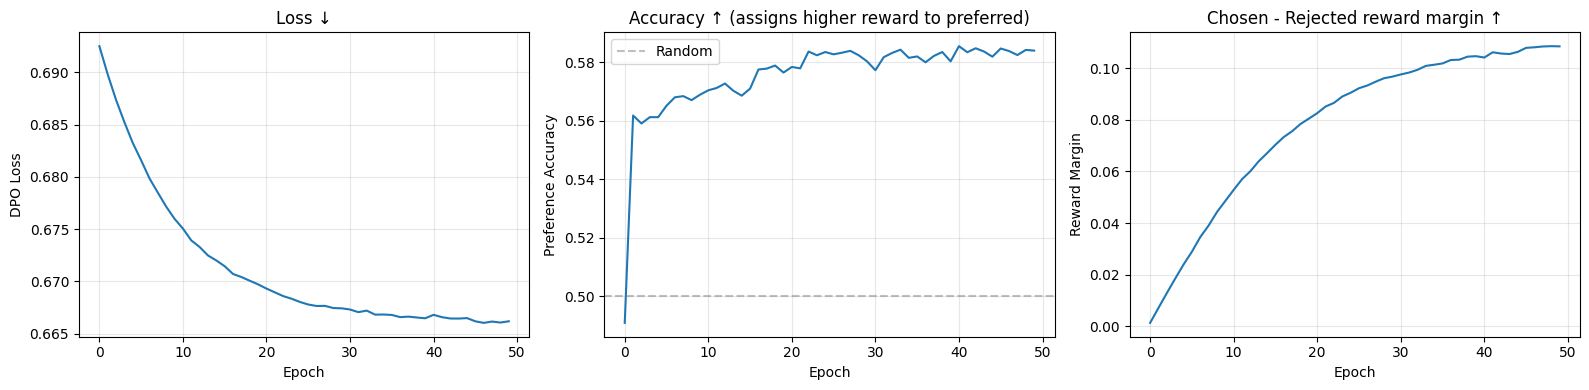

In [7]:
# Plot DPO training
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
ax.plot(dpo_history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('DPO Loss')
ax.set_title('Loss ↓')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(dpo_history['accuracy'])
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
ax.set_xlabel('Epoch')
ax.set_ylabel('Preference Accuracy')
ax.set_title('Accuracy ↑ (assigns higher reward to preferred)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(dpo_history['reward_margin'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Reward Margin')
ax.set_title('Chosen - Rejected reward margin ↑')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Compare SFT vs DPO
print("Performance comparison (true reward):\n")

sft_total, dpo_total = 0, 0
for ctx in range(N_CONTEXTS):
    sft_r = np.mean([get_true_reward(ctx, sft_model.generate(ctx)) for _ in range(200)])
    dpo_r = np.mean([get_true_reward(ctx, dpo_policy.generate(ctx)) for _ in range(200)])
    print(f"Context {ctx}: SFT={sft_r:.4f}  DPO={dpo_r:.4f}  {'✓' if dpo_r > sft_r else '✗'}")
    sft_total += sft_r
    dpo_total += dpo_r

print(f"\nOverall: SFT={sft_total/N_CONTEXTS:.4f}  DPO={dpo_total/N_CONTEXTS:.4f}")

Performance comparison (true reward):

Context 0: SFT=0.3900  DPO=0.5783  ✓
Context 1: SFT=0.2837  DPO=0.4699  ✓
Context 2: SFT=0.7829  DPO=0.8543  ✓
Context 3: SFT=0.3765  DPO=0.2242  ✗
Context 4: SFT=0.9925  DPO=0.9925  ✗

Overall: SFT=0.5651  DPO=0.6238


---
## 4. DPO β Ablation

β controls how strongly the model moves away from the reference.
- **Small β**: Aggressive optimization, can overfit to preferences
- **Large β**: Conservative, stays close to SFT

In [9]:
beta_results = {}
for beta in [0.01, 0.1, 0.5, 2.0]:
    print(f"\nβ={beta}...")
    policy, history = train_dpo(sft_model, preference_data, beta=beta, n_epochs=50)
    
    # Evaluate
    rewards = []
    for ctx in range(N_CONTEXTS):
        r = np.mean([get_true_reward(ctx, policy.generate(ctx)) for _ in range(200)])
        rewards.append(r)
    avg_reward = np.mean(rewards)
    
    beta_results[f"β={beta}"] = {'history': history, 'avg_reward': avg_reward}
    print(f"  Avg reward: {avg_reward:.4f}")


β=0.01...
Epoch 10: loss=0.6897, acc=56.5%, margin=0.0074
Epoch 20: loss=0.6841, acc=57.2%, margin=0.0207
Epoch 30: loss=0.6782, acc=57.5%, margin=0.0386
Epoch 40: loss=0.6740, acc=57.6%, margin=0.0554
Epoch 50: loss=0.6714, acc=57.9%, margin=0.0689
  Avg reward: 0.6117

β=0.1...
Epoch 10: loss=0.6763, acc=56.8%, margin=0.0475
Epoch 20: loss=0.6697, acc=57.7%, margin=0.0796
Epoch 30: loss=0.6675, acc=58.3%, margin=0.0963
Epoch 40: loss=0.6666, acc=58.2%, margin=0.1040
Epoch 50: loss=0.6659, acc=58.0%, margin=0.1088
  Avg reward: 0.6223

β=0.5...
Epoch 10: loss=0.6688, acc=58.4%, margin=0.0901
Epoch 20: loss=0.6670, acc=57.8%, margin=0.1064
Epoch 30: loss=0.6670, acc=58.5%, margin=0.1118
Epoch 40: loss=0.6669, acc=58.7%, margin=0.1125
Epoch 50: loss=0.6666, acc=58.5%, margin=0.1128
  Avg reward: 0.6090

β=2.0...
Epoch 10: loss=0.6712, acc=56.7%, margin=0.1085
Epoch 20: loss=0.6709, acc=57.3%, margin=0.1037
Epoch 30: loss=0.6709, acc=57.0%, margin=0.1044
Epoch 40: loss=0.6706, acc=57.3%

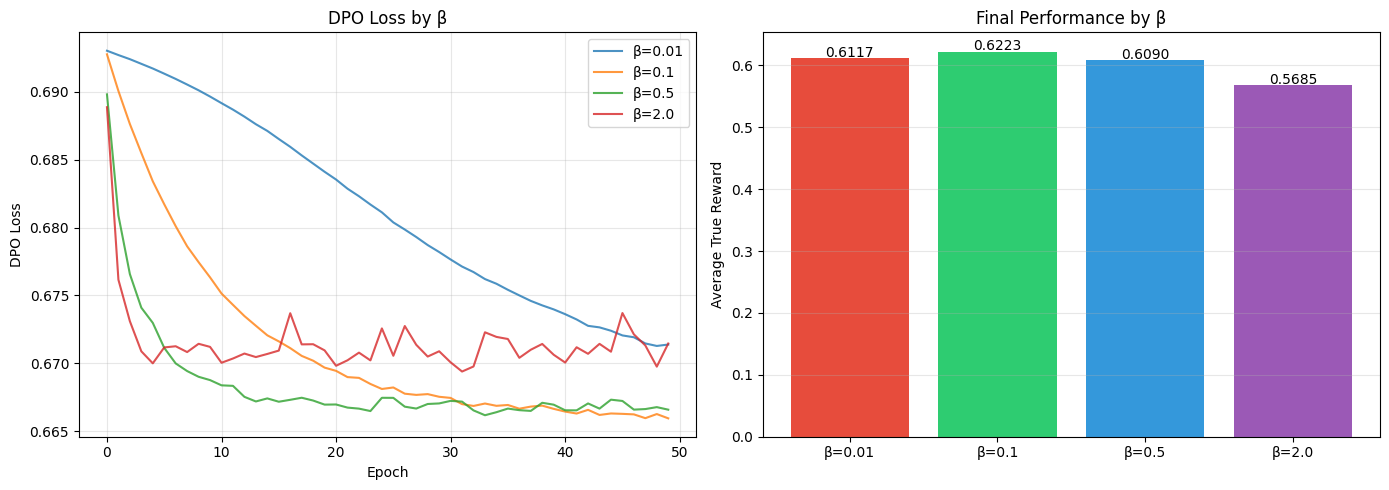

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for label, data in beta_results.items():
    ax.plot(data['history']['loss'], label=label, alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('DPO Loss')
ax.set_title('DPO Loss by β')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
betas = list(beta_results.keys())
rewards = [beta_results[b]['avg_reward'] for b in betas]
colors = ['#e74c3c', '#2ecc71', '#3498db', '#9b59b6']
bars = ax.bar(betas, rewards, color=colors)
ax.set_ylabel('Average True Reward')
ax.set_title('Final Performance by β')
for bar, r in zip(bars, rewards):
    ax.text(bar.get_x() + bar.get_width()/2, r + 0.002, f'{r:.4f}', ha='center')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 5. DPO vs RLHF: Side by Side

### Conceptual Comparison

| Aspect | RLHF (PPO) | DPO |
|--------|-----------|-----|
| **Pipeline** | SFT → RM → PPO | SFT → DPO |
| **Reward model** | Explicit (trained separately) | Implicit (embedded in policy) |
| **Optimization** | On-policy RL (PPO) | Supervised learning |
| **Stability** | Sensitive to hyperparams | More stable |
| **Compute** | High (RL rollouts) | Lower (just forward/backward) |
| **Reward hacking** | Possible | Less likely (no explicit RM) |

### The Implicit Reward

DPO defines an **implicit reward** through the policy itself:

$$r(x, y) = \beta \log \frac{\pi_\theta(y|x)}{\pi_{ref}(y|x)}$$

Higher log-ratio = model thinks this response is better than reference would.

### When to Use Which?

| Use DPO when... | Use RLHF when... |
|-----------------|------------------|
| You have preference data | You need online exploration |
| Simplicity matters | You need an explicit reward signal |
| Limited compute | You want to iterate on the reward model |
| Offline training is fine | Online data collection is feasible |

---
## 6. DPO Variants

DPO spawned many variants:

| Variant | Key Idea |
|---------|----------|
| **IPO** (Identity PO) | Uses identity function instead of sigmoid, more robust |
| **KTO** (Kahneman-Tversky) | Works with just good/bad labels, no pairs needed |
| **ORPO** (Odds Ratio PO) | Combines SFT and preference in one loss |
| **SimPO** (Simple PO) | Reference-free, uses length-normalized log-probs |

---

## Key Takeaways

1. **DPO skips the reward model** by showing the optimal policy has a closed-form solution

2. **The DPO loss** directly increases probability of preferred responses relative to rejected ones

3. **β controls aggressiveness**: how far the model moves from the reference

4. **Simpler than RLHF**: just supervised training on preference pairs

5. **Trade-off**: DPO is offline (fixed dataset), RLHF can do online exploration

---
**Next**: GRPO — DeepSeek's approach that brings back RL but simplifies the critic